In [ ]:
from datetime import datetime
import os

import requests
from PIL import Image
import io
import numpy as np
from skimage.color import rgb2gray
import urllib.parse
import polyline
from IPython.display import display, Markdown
import pyproj
import random

In [ ]:
los_angeles = [
    {'n': 34.269260, 'w': -118.604202, 's': 34.171040, 'e': -118.370722},
    {'n': 34.100406, 'w': -118.362530, 's': 33.797995, 'e': -117.863483},
    {'n': 33.714559, 'w': -118.033473, 's': 33.636157, 'e': -117.746060}
]

chicago = [
    {'n': 42.072123, 'w': -88.311501, 's': 41.643560, 'e': -87.682533}
]

houston = [
    {'n': 29.875249, 'w': -95.563377, 's': 29.610542, 'e': -95.189842}
]

phoenix = [
    {'n': 33.688554, 'w': -112.381892, 's': 33.392095, 'e': -111.887507}
]

philadelphia = [
    {'n': 40.052889, 'w': -75.233393, 's': 39.904511, 'e': -75.140009},
    {'n': 40.049736, 'w': -75.144129, 's': 40.026079, 'e': -75.027399}
]

san_francisco = [
    {'n': 37.801910, 'w': -122.506267, 's': 37.737590, 'e': -122.398120},
    {'n': 37.826862, 'w': -122.295123, 's': 37.800282, 'e': -122.255984}
]

boston = [
    {'n': 42.387338, 'w': -71.141267, 's': 42.283792, 'e': -71.046510}
]

cities_boxes = [los_angeles, chicago, houston, phoenix, philadelphia, san_francisco, boston]
cities = {
    'Los Angeles': los_angeles,
    'Chicago': chicago,
    'Houston': houston,
    'Phoenix': phoenix,
    'Philadelphia': philadelphia,
    'San Francisco': san_francisco,
    'Boston': boston
}

In [ ]:
GOOGLE_API_KEY=os.environ['GOOGLE_API_KEY']

def maps_static_api(lat=None, lon=None, width=512, height=512, zoom=None, querystring=None, **kwargs):
    url = 'https://maps.googleapis.com/maps/api/staticmap?size={width}x{height}{center_par}{zoom_par}{additional_params}'.format(
        width=width, height=height,
        center_par="&center={lat},{lon}".format(lat=lat, lon=lon) if (lat and lon) else "",
        zoom_par="&zoom={}".format(zoom) if zoom else "",
        additional_params="&{}".format(querystring) if querystring else "",
        api_key=GOOGLE_API_KEY)+"&"+urllib.parse.urlencode(kwargs) + "&key="+GOOGLE_API_KEY
    response = requests.get(url)
    if (response.status_code // 100 != 2):
        raise Exception(response.content)
    img_tmp = Image.open(io.BytesIO(response.content))
    return img_tmp.convert('RGB')

## Los Angeles

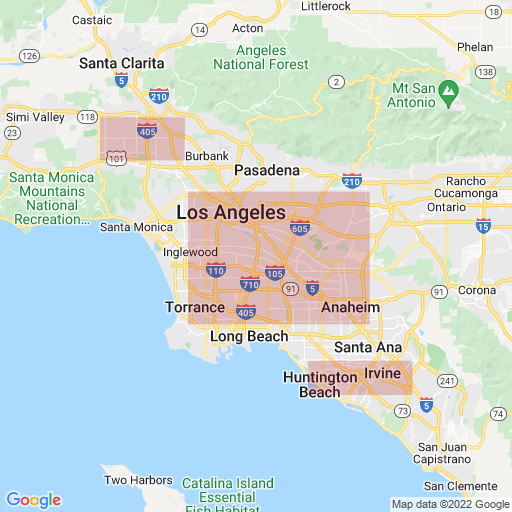

## Chicago

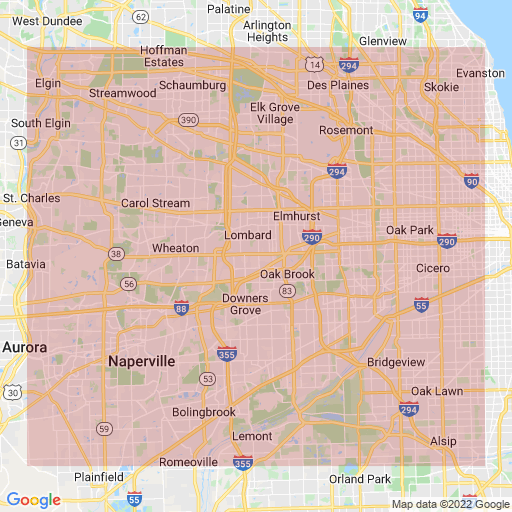

## Houston

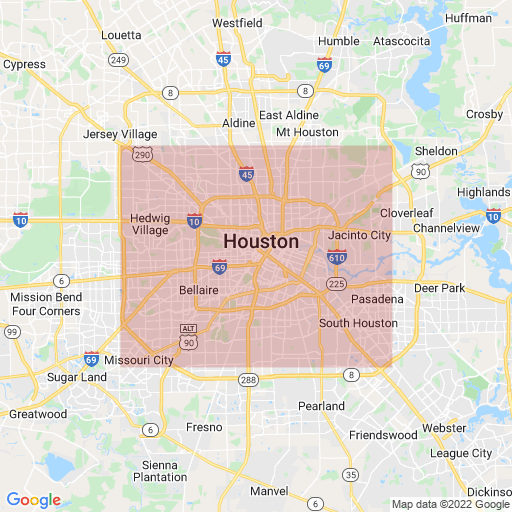

## Phoenix

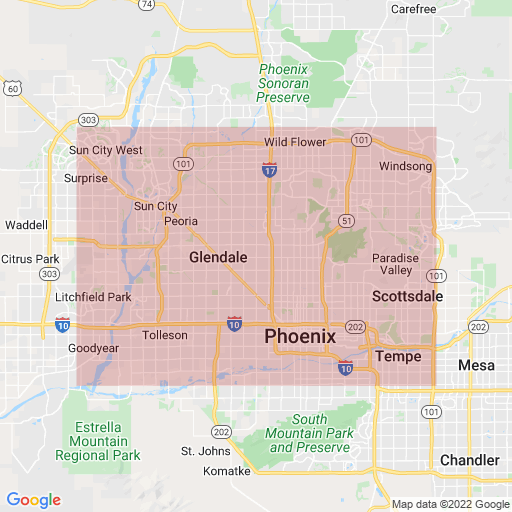

## Philadelphia

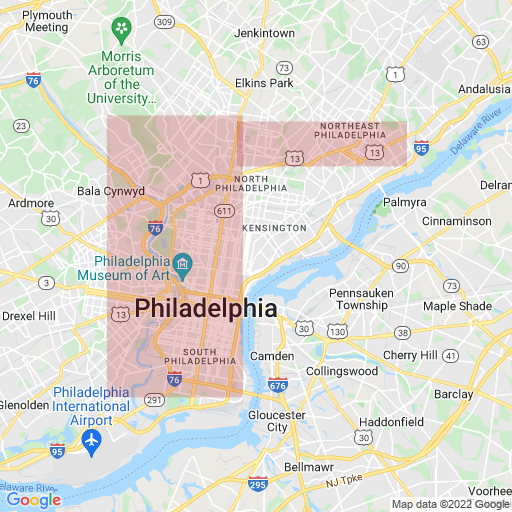

## San Francisco

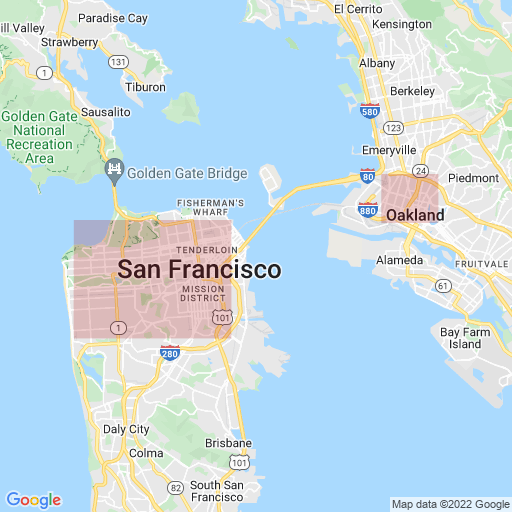

## Boston

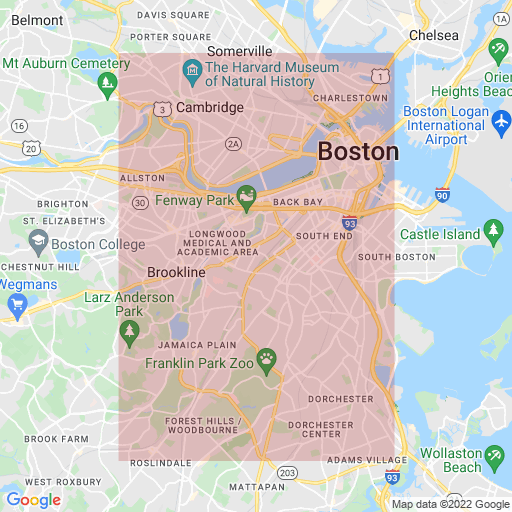

In [ ]:
def area_polyline(area):
    path = [
        (area['n'], area['w']),
        (area['n'], area['e']),
        (area['s'], area['e']),
        (area['s'], area['w']),
    ]
    return polyline.encode(path, 5)

def area_path_parameter(area):
    return "fillcolor:0xAA000033|color:0xFFFFFF00|enc:{enc}".format(enc=area_polyline(area))

def city_overview_map(areas):
    querystring = "&".join(map(lambda arg: "path={}".format(arg), map(area_path_parameter, areas)))
    img_overview = maps_static_api(
        querystring=querystring
    )
    return img_overview

for name, city in cities.items():
    display(Markdown('## '+name))
    display(city_overview_map(city))

In [ ]:
# def pick_random_center_from_city(city_boxes):
#     index = np.random.randint(len(city_boxes))
#     box = city_boxes[index]

#     rand_x = np.random.uniform(box['w'], box['e'])
#     rand_y = np.random.uniform(box['n'], box['s'])

#     return rand_x, rand_y

# def pick_random_center(cities_boxes):
#     city_nr = np.random.randint(len(cities_boxes)) #pick a city
#     return pick_random_center_from_city(cities_boxes[city_nr])

def pick_random_centers(boxes):
    centers = []
    for box in boxes:
        rand_x = np.random.uniform(box['w'], box['e'])
        rand_y = np.random.uniform(box['n'], box['s'])
        centers.append((rand_x, rand_y))
    return centers

def pick_random_areas(city, n=1):
    geod = Geod('+a=6378137 +f=0.0033528106647475126')
    def area_weight(area):
        coordinates = np.array([
            (area['n'], area['w']),
            (area['n'], area['e']),
            (area['s'], area['e']),
            (area['s'], area['w']),
        ])
        lats = coordinates[:,0]
        lons = coordinates[:,1]
        area_m, _ = geod.polygon_area_perimeter(lons, lats)
        return abs(area_m) # Positive is counterclockwise, the data is clockwise.
    choices = [area for area in city]
    weights = [area_weight(area) for area in city]
    p = np.asarray(weights).astype('float64')
    p = p / np.sum(p)
    
    #samples = random.choices(choices, weights, k=n)
    samples = np.random.choice(len(choices), size=n, replace=True, p=p)
    samples = [choices[x] for x in samples]
    return samples

In [ ]:
def download_map_sample(lat, lon, zoom=18, target_width=400, target_height=400):
    bottom_crop = 20
    args = {
        "lat": lat,
        "lon": lon,
        "zoom": zoom,
        "width": target_width+bottom_crop,
        "height": target_height+bottom_crop
    }
    img_sat = maps_static_api(
        maptype="satellite",
        **args
    )
    img_sat = img_sat.crop(box=(0,0,target_width, target_height)) # remove pixels at the bottom
    img_mask = maps_static_api(
        maptype="roadmap",
        map_id="7ed943b30af08eea",
        **args
    )
    img_mask = img_mask.crop(box=(0,0,target_width, target_height)) # remove pixels at the bottom
    return img_sat, img_mask

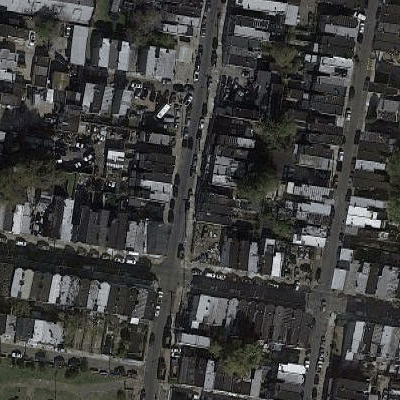

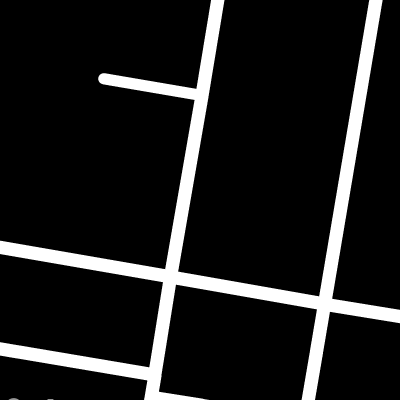

In [ ]:
city_nr = np.random.randint(len(cities_boxes)) #pick a city
x, y = pick_random_centers(pick_random_areas(cities_boxes[city_nr], n=1))[0]
sat, mask = download_map_sample(y, x)
display(sat)
display(mask)

In [ ]:
from skimage.io import imsave
from pathlib import Path

dataset_directory = os.getenv('DATASET_DIR', "../gmaps_dataset/")

def save_image(name, image, mask, img_path, mask_path):
    imsave(img_path, np.array(image.convert('RGB')).astype(np.uint8))
    # the following removes anti-aliasing
    mask_arrray = (np.array(mask.convert('RGB')).astype(bool)*255)
    imsave(mask_path, mask_arrray.astype(np.uint8))

def download_dataset(dataset_sources, seed, force_download=False):
    np.random.seed(seed)
    Path(os.path.join(dataset_directory, "images")).mkdir(parents=True, exist_ok=True)
    Path(os.path.join(dataset_directory, "masks")).mkdir(parents=True, exist_ok=True)
    for name, city_boxes, count in dataset_sources:
        samples = pick_random_centers(pick_random_areas(city_boxes, n=count))
        for i in range(count):
            x, y = samples[i]
            print(x, y)
            img_path = os.path.join(dataset_directory, "images", "{}_{}.png".format(name, i+1))
            mask_path = os.path.join(dataset_directory, "masks", "{}_{}.png".format(name, i+1))
            
            if (os.path.isfile(img_path) and os.path.isfile(mask_path)) and (not force_download):
                print("Already exists: {}_{}.png".format(name, i+1))
            else:
                sat, mask = download_map_sample(y, x)
                save_image(name, sat, mask, img_path, mask_path)
                print("Saved {}_{}.png".format(name, i+1))
    print("DONE")

In [ ]:
dataset_sources = [
    ("los_angeles", los_angeles, 50),
    ("chicago", chicago, 50),
    ("houston", houston, 50),
    ("phoenix", phoenix, 50),
    ("philadelphia", philadelphia, 50),
    ("san_francisco", san_francisco, 50),
    ("boston", boston, 50),
]
download_dataset(dataset_sources, seed=42)

-117.87866170026798 33.86599730775454
Already exists: los_angeles_1.png
-117.76344879070821 33.64440274607177
Already exists: los_angeles_2.png
-118.06414980927427 33.821621090712426
Already exists: los_angeles_3.png
-118.3183680823285 34.04113862659296
Already exists: los_angeles_4.png
-118.33995945715107 34.00202252934355
Already exists: los_angeles_5.png
-118.16856176461233 34.01834706795223
Already exists: los_angeles_6.png
-118.41070836636321 34.23421968825215
Already exists: los_angeles_7.png
-118.22233047574404 33.93628873479603
Already exists: los_angeles_8.png
-118.29220218829903 33.85781280885319
Already exists: los_angeles_9.png
-118.32532572492354 33.8019605346157
Already exists: los_angeles_10.png
-118.42389829126462 34.24974214575972
Already exists: los_angeles_11.png
-118.03188587175116 33.650625193086285
Already exists: los_angeles_12.png
-118.00977496312488 33.87994621330556
Already exists: los_angeles_13.png
-117.97762984729742 34.07801408282444
Already exists: los_an

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ddedec99-c003-49f8-9064-90484ffbe195' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>